# <center> Railroad Segmentation (using SMP) </center>

In [0]:
!pip install -U segmentation-models-pytorch

In [0]:
import segmentation_models_pytorch as SMP
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import os

#### Constants

In [0]:
GOOGLE_COLAB = True

DATA_DIR = 'segmentation/data/segmentation_data/'
if not GOOGLE_COLAB:
    DATA_DIR = os.path.realpath(DATA_DIR)

FEATURES = ['roads', 'railroads', 'wetlands']
POSITIVE = 'railroads'
NEGATIVE = [feature for feature in FEATURES if feature != POSITIVE]

N_SAMPLES = 400 # for each class
N_AUG_POS = 4
N_AUG_NEG = 0
N_POS = N_SAMPLES // N_AUG_POS
N_NEG = N_SAMPLES

BATCH_SIZE = 10

ROTATION_RANGE = 180
WINDOW_SIZE = 320

NUM_WORKERS = 2

N_EPOCHS = 40
LEARNING_RATE = 0.0001
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
AUX_BRANCH = None

LOAD_MODEL = False
LOAD_MODEL_PATH = 'checkpoints/%s_best.pth'
CHECKPOINTS_DIR = 'checkpoints/'
SAVE_MODEL_PATH = os.path.join(CHECKPOINTS_DIR, '%s_best.pth')

MASK_THRESHOLD = 0.5

NORMALIZE = False

#### Settings for Google Collaboratory

In [3]:
if GOOGLE_COLAB:
    from google.colab import drive
    
    DATA_DIR = 'segmentation_data/'

    drive.mount('/content/drive/')
    os.chdir('/content/drive/My Drive')

    assert os.path.exists(DATA_DIR), 'DATA_DIR does not exist in path'
    assert os.path.exists(CHECKPOINTS_DIR), 'CHECKPOINTS_DIR does not exist'
    
    import sys
    sys.path.append('/content/drive/My Drive')
    
    NUM_WORKERS = 10
    BATCH_SIZE = 20
    

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from data_handler import get_data, sample_points
from transformer import SegmentationTransform
from utils import *

#### Starting with data

- Read dir to gather files
- Maps start with 'map_'
- Masks start with 'mask_'
- Rest have class type in their names
    - eg. railroads.txt

In [0]:
maps, masks, neg_files = get_filepaths(DATA_DIR, POSITIVE, NEGATIVE)

- Load maps and masks
- Caching them since maps are heavy (heavy IO)

In [6]:
LOADED_MAPS = load_images(maps)
LOADED_MASKS = load_images(masks, grayscale=True)
LOADED_MAPS[0].shape, LOADED_MASKS[0].shape

((13696, 11347, 3), (13696, 11347))

In [0]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(16,5))
# plt.subplot(1,2,1)
# plt.imshow(LOADED_MAPS[1])
# plt.subplot(1,2,2)
# plt.imshow(LOADED_MASKS[1], cmap='gray')
# plt.show()

- Sample N_POS pixels (white) from all the pixels that belong to the positive class and write to pos.txt
- Sample N_NEG pixels (black) for each of the negative class and write to neg{}.txt

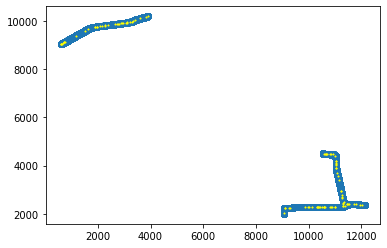

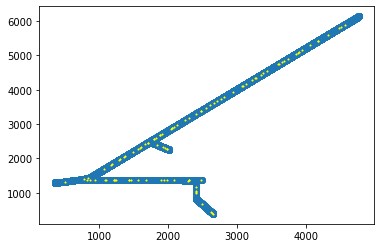

In [8]:
sample_points(maps, masks, neg_files, N_POS, N_NEG, representors=False, plot_pos=True)

#### Create Datasets and Data Loaders

In [0]:
class SegmentationDataset(Dataset):
	def __init__(self, data_points, transformer, win_size, scale=False):
		self.dataset = data_points
		self.transformer = transformer
		self.win_size = win_size
		self.scale = scale
		
	def preprocess(self, data_point):
		data_point = self.transformer(data_point)
		# mask channels == n_classes?
		
#         data_point['image'] = data_point['mask'].to(torch.float64)
#         data_point['mask'] = data_point['mask'].to(torch.long)
#         if self.scale: # totensor transform has done that for us
#             data_point['image'] /= 255.
#             data_point['mask'] /= 255
		return data_point
		
	def __len__(self):
		return len(self.dataset)
	
	def __getitem__(self, ix):
		assert ix < self.__len__(), 'Index must be within bounds (<len)'
		sample = self.preprocess(self.dataset[ix])
		return sample['images'], sample['masks']

In [10]:
# Default: val_size=0.1, shuffle=True, augment=True

train_data, val_data = get_data(maps, LOADED_MAPS, N_AUG_POS, N_AUG_NEG, WINDOW_SIZE, ROTATION_RANGE)
n_train, n_val = len(train_data), len(val_data)
n_train, n_val

(1620, 180)

In [0]:
if NORMALIZE:
    image_tf = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    transformer = SegmentationTransform(LOADED_MAPS, LOADED_MASKS, WINDOW_SIZE, image_tf=image_tf)
else:
    transformer = SegmentationTransform(LOADED_MAPS, LOADED_MASKS, WINDOW_SIZE)

In [0]:
train_dataset = SegmentationDataset(train_data, transformer, WINDOW_SIZE)
val_dataset = SegmentationDataset(val_data, transformer, WINDOW_SIZE)

In [0]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=True, pin_memory=True)

#### Simple Tests

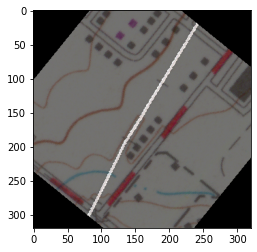

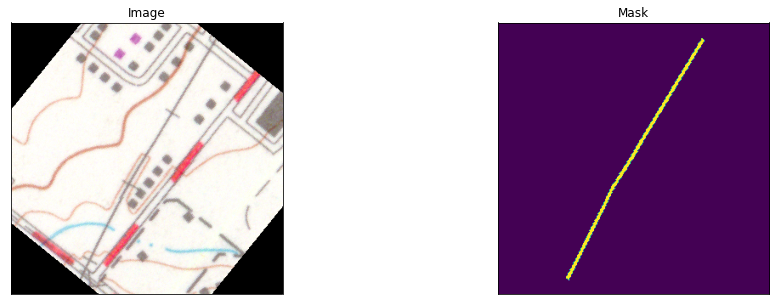

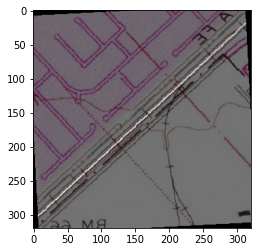

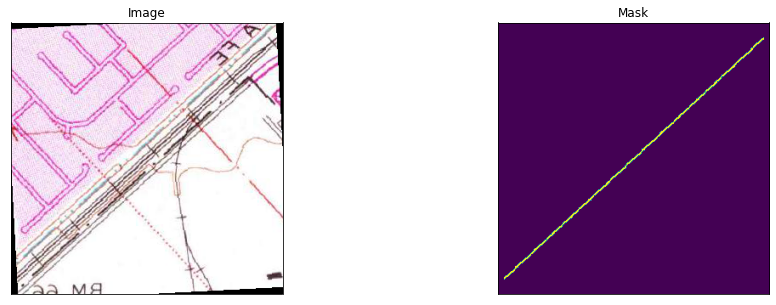

In [14]:
for i in np.random.choice(n_train, 2):
    image, mask = train_dataset[i]
    plot_overlay(image, mask)
    image = image.numpy().transpose((2,1,0))
    mask = mask.numpy().transpose((2,1,0)).squeeze()
    plot_segmentation_row(image=image, mask=mask)

### Load Model

In [0]:
MODEL_NAME = 'pspnet_resnet50'
model = SMP.PSPNet(encoder_name='resnet50', encoder_weights='imagenet', classes=1, activation='sigmoid')

In [0]:
LOAD_MODEL = False

if LOAD_MODEL:
    model = torch.load(LOAD_MODEL_PATH % MODEL_NAME, map_location=DEVICE)
    
model = model.to(device=DEVICE)

### Training

In [0]:
metrics = [
    SMP.utils.metrics.IoU(threshold=0.5)
]
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1)
criterion = SMP.utils.losses.DiceLoss()
writer = SummaryWriter()

In [19]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 724), started 0:00:04 ago. (Use '!kill 724' to kill it.)

<IPython.core.display.Javascript object>

In [0]:
trainer = SMP.utils.train.TrainEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

validator = SMP.utils.train.ValidEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

In [21]:
LOAD_MODEL_PATH % MODEL_NAME, SAVE_MODEL_PATH % MODEL_NAME

('checkpoints/pspnet_resnet50_best.pth',
 'checkpoints/pspnet_resnet50_best.pth')

In [22]:
EARLY_STOPPING_PATIENCE = 1

monitor = {'val_loss': np.inf, 'val_score': -np.inf, 'patience': EARLY_STOPPING_PATIENCE, 'best_score': -np.inf}

for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch}   lr {optimizer.param_groups[0]['lr']}")
    train_logs = trainer.run(train_loader)
    valid_logs = validator.run(val_loader)
    
    scheduler.step(valid_logs['dice_loss'])
          
    writer.add_scalar('dice_loss/train', train_logs['dice_loss'], epoch)
    writer.add_scalar('iou_score/train', train_logs['iou_score'], epoch)
    writer.add_scalar('dice_loss/test', valid_logs['dice_loss'], epoch)
    writer.add_scalar('iou_score/test', valid_logs['iou_score'], epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)
          
    # Early stopping
#     if monitor['val_score'] > valid_logs['iou_score']: # prev_iou > current_iou
          
    if monitor['val_loss'] < valid_logs['dice_loss']: # prev_loss < current_loss
        if monitor['patience'] == 0:
            print("---- TRAINING STOPPED ----")
            break
        else:
            print(f"-- Monitoring for {monitor['patience']} more epoch(s) --")
            monitor['patience'] -= 1
            
    else:
        monitor['patience'] = EARLY_STOPPING_PATIENCE
        
    
    if valid_logs['iou_score'] > monitor['best_score']:
        monitor['best_score'] = valid_logs['iou_score']
        torch.save(model, SAVE_MODEL_PATH % MODEL_NAME)
        print("---- MODEL SAVED ----")
    
    monitor['val_loss'] = valid_logs['dice_loss']
    monitor['val_score'] = valid_logs['iou_score']

Epoch 0   lr 0.0001
valid: 100%|██████████| 9/9 [00:33<00:00,  3.73s/it, dice_loss - 0.7196, iou_score - 0.1593]
Epoch 1   lr 0.0001
valid: 100%|██████████| 9/9 [00:33<00:00,  3.74s/it, dice_loss - 0.5138, iou_score - 0.3477]
Epoch 2   lr 0.0001
valid: 100%|██████████| 9/9 [00:34<00:00,  3.79s/it, dice_loss - 0.4673, iou_score - 0.3859]
Epoch 3   lr 0.0001
valid: 100%|██████████| 9/9 [00:34<00:00,  3.82s/it, dice_loss - 0.4437, iou_score - 0.4054]
Epoch 4   lr 0.0001
valid: 100%|██████████| 9/9 [00:34<00:00,  3.80s/it, dice_loss - 0.4234, iou_score - 0.4182]
Epoch 5   lr 0.0001
valid: 100%|██████████| 9/9 [00:34<00:00,  3.78s/it, dice_loss - 0.4004, iou_score - 0.4506]
Epoch 6   lr 0.0001
valid: 100%|██████████| 9/9 [00:33<00:00,  3.76s/it, dice_loss - 0.3923, iou_score - 0.453]
Epoch 7   lr 0.0001
valid: 100%|██████████| 9/9 [00:34<00:00,  3.79s/it, dice_loss - 0.384, iou_score - 0.4616]
Epoch 8   lr 0.0001
valid: 100%|██████████| 9/9 [00:34<00:00,  3.81s/it, dice_loss - 0.3859, iou_s

KeyboardInterrupt: ignored

In [23]:
print(monitor)
# Decrease LR
optimizer.param_groups[0]['lr'] *=  0.1

for epoch in range(26, N_EPOCHS):
    print(f"Epoch {epoch}   lr {optimizer.param_groups[0]['lr']}")
    train_logs = trainer.run(train_loader)
    valid_logs = validator.run(val_loader)
    
    scheduler.step(valid_logs['dice_loss'])
          
    writer.add_scalar('dice_loss/train', train_logs['dice_loss'], epoch)
    writer.add_scalar('iou_score/train', train_logs['iou_score'], epoch)
    writer.add_scalar('dice_loss/test', valid_logs['dice_loss'], epoch)
    writer.add_scalar('iou_score/test', valid_logs['iou_score'], epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)
          
    # Early stopping
#     if monitor['val_score'] > valid_logs['iou_score']: # prev_iou > current_iou
          
    if monitor['val_loss'] < valid_logs['dice_loss']: # prev_loss < current_loss
        if monitor['patience'] == 0:
            print("---- TRAINING STOPPED ----")
            break
        else:
            print(f"-- Monitoring for {monitor['patience']} more epoch(s) --")
            monitor['patience'] -= 1
            
    else:
        monitor['patience'] = EARLY_STOPPING_PATIENCE
        
    
    if valid_logs['iou_score'] > monitor['best_score']:
        monitor['best_score'] = valid_logs['iou_score']
        torch.save(model, SAVE_MODEL_PATH % MODEL_NAME)
        print("---- MODEL SAVED ----")
    
    monitor['val_loss'] = valid_logs['dice_loss']
    monitor['val_score'] = valid_logs['iou_score']

{'val_loss': 0.32812504635916817, 'val_score': 0.5146225955751207, 'patience': 0, 'best_score': 0.5228025979465909}
Epoch 26   lr 1e-05
valid: 100%|██████████| 9/9 [00:33<00:00,  3.76s/it, dice_loss - 0.3182, iou_score - 0.5272]
---- MODEL SAVED ----
Epoch 27   lr 1e-05
valid: 100%|██████████| 9/9 [00:33<00:00,  3.74s/it, dice_loss - 0.3189, iou_score - 0.5269]
-- Monitoring for 1 more epoch(s) --
Epoch 28   lr 1e-05
valid: 100%|██████████| 9/9 [00:33<00:00,  3.72s/it, dice_loss - 0.3172, iou_score - 0.5288]
---- MODEL SAVED ----
Epoch 29   lr 1e-05
valid: 100%|██████████| 9/9 [00:33<00:00,  3.71s/it, dice_loss - 0.3167, iou_score - 0.5302]
---- MODEL SAVED ----
Epoch 30   lr 1e-05
train:   0%|          | 0/81 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

In [24]:
print(monitor)
# Decrease LR
optimizer.param_groups[0]['lr'] *=  0.1

for epoch in range(26, N_EPOCHS):
    print(f"Epoch {epoch}   lr {optimizer.param_groups[0]['lr']}")
    train_logs = trainer.run(train_loader)
    valid_logs = validator.run(val_loader)
    
    scheduler.step(valid_logs['dice_loss'])
          
    writer.add_scalar('dice_loss/train', train_logs['dice_loss'], epoch)
    writer.add_scalar('iou_score/train', train_logs['iou_score'], epoch)
    writer.add_scalar('dice_loss/test', valid_logs['dice_loss'], epoch)
    writer.add_scalar('iou_score/test', valid_logs['iou_score'], epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)
          
    # Early stopping
#     if monitor['val_score'] > valid_logs['iou_score']: # prev_iou > current_iou
          
    if monitor['val_loss'] < valid_logs['dice_loss']: # prev_loss < current_loss
        if monitor['patience'] == 0:
            print("---- TRAINING STOPPED ----")
            break
        else:
            print(f"-- Monitoring for {monitor['patience']} more epoch(s) --")
            monitor['patience'] -= 1
            
    else:
        monitor['patience'] = EARLY_STOPPING_PATIENCE
        
    
    if valid_logs['iou_score'] > monitor['best_score']:
        monitor['best_score'] = valid_logs['iou_score']
        torch.save(model, SAVE_MODEL_PATH % MODEL_NAME)
        print("---- MODEL SAVED ----")
    
    monitor['val_loss'] = valid_logs['dice_loss']
    monitor['val_score'] = valid_logs['iou_score']

{'val_loss': 0.31670818063947886, 'val_score': 0.530154009660085, 'patience': 1, 'best_score': 0.530154009660085}
Epoch 26   lr 1.0000000000000002e-06
valid: 100%|██████████| 9/9 [00:33<00:00,  3.72s/it, dice_loss - 0.3167, iou_score - 0.53]
Epoch 27   lr 1.0000000000000002e-06
train:   0%|          | 0/81 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

In [25]:
print(monitor)
# Decrease LR
optimizer.param_groups[0]['lr'] *=  0.01

for epoch in range(27, N_EPOCHS):
    print(f"Epoch {epoch}   lr {optimizer.param_groups[0]['lr']}")
    train_logs = trainer.run(train_loader)
    valid_logs = validator.run(val_loader)
    
    scheduler.step(valid_logs['dice_loss'])
          
    writer.add_scalar('dice_loss/train', train_logs['dice_loss'], epoch)
    writer.add_scalar('iou_score/train', train_logs['iou_score'], epoch)
    writer.add_scalar('dice_loss/test', valid_logs['dice_loss'], epoch)
    writer.add_scalar('iou_score/test', valid_logs['iou_score'], epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)
          
    # Early stopping
#     if monitor['val_score'] > valid_logs['iou_score']: # prev_iou > current_iou
          
    if monitor['val_loss'] < valid_logs['dice_loss']: # prev_loss < current_loss
        if monitor['patience'] == 0:
            print("---- TRAINING STOPPED ----")
            break
        else:
            print(f"-- Monitoring for {monitor['patience']} more epoch(s) --")
            monitor['patience'] -= 1
            
    else:
        monitor['patience'] = EARLY_STOPPING_PATIENCE
        
    
    if valid_logs['iou_score'] > monitor['best_score']:
        monitor['best_score'] = valid_logs['iou_score']
        torch.save(model, SAVE_MODEL_PATH % MODEL_NAME)
        print("---- MODEL SAVED ----")
    
    monitor['val_loss'] = valid_logs['dice_loss']
    monitor['val_score'] = valid_logs['iou_score']

{'val_loss': 0.31665951013565063, 'val_score': 0.5299773216247559, 'patience': 1, 'best_score': 0.530154009660085}
Epoch 27   lr 1.0000000000000002e-08
valid: 100%|██████████| 9/9 [00:34<00:00,  3.82s/it, dice_loss - 0.3167, iou_score - 0.5297]
-- Monitoring for 1 more epoch(s) --
Epoch 28   lr 1.0000000000000002e-08
train:   0%|          | 0/81 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

### Model wouldn't converge further. Stopping training.

In [0]:
model = torch.load(LOAD_MODEL_PATH % MODEL_NAME, map_location=DEVICE)

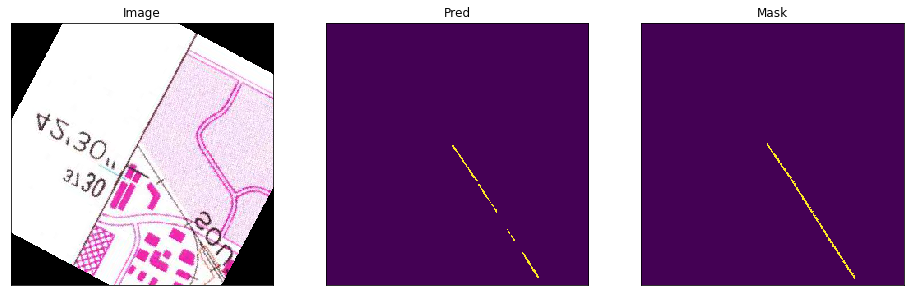

In [0]:
# image, mask = train_dataset[210]
# pred = (model(image.unsqueeze(0)).squeeze(0) > MASK_THRESHOLD).to(torch.uint8)
# image, pred, mask = image.detach().numpy().transpose((2,1,0)), pred.detach().numpy().transpose((2,1,0)), mask.detach().numpy().transpose((2,1,0))
# plot_segmentation_row(image=image, pred=pred.squeeze(), mask=mask.squeeze())

In [0]:
# test_image = ''

In [0]:
# import tifffile


# test_image = tifffile.imread(test_image)
# batch_generator = make_batch(test_image, WINDOW_SIZE, stride=100, batch_size=10, start_row=8000, start_col=10500)

In [0]:
# for batch in batch_generator:
#     batch = batch[0]
#     pred = (model(batch))# > MASK_THRESHOLD).to(dtype=torch.uint8)
#     for i in range(batch.size(0)):
#         image = batch[i].detach().numpy().transpose((2,1,0))
#         mask = pred[i].detach().numpy().transpose((2,1,0))
#         plot_segmentation_row(image=image, pred_mask=mask.squeeze())
#         plt.show()
#         input()